In [2]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np

In [3]:

def preprocess_audio(audio_file, 
                     downsample=1, 
                     secs_per_fn=1, 
                     verbose=False):
    '''
    This function takes in an mp3 file and preprocesses it for our neural operator model. 

    Args:
    downsample: int = if 2, takes every other point from original audio array, if 4 every fourth point
                        this is to save computation, whats great about operators is that any resolution of
                        audio data can be processed by the same model!
    secs_per_fn: float = how many seconds of audio in one function example? 
    verbose: bool = print info about the created audio array 
    '''
    
    sps = librosa.get_samplerate(audio_file) ### samples per second
    downsample_sps = sps // downsample
    audio_data, sr = librosa.load(audio_file, sr=downsample_sps)
    audio_array = np.array(audio_data)

    ### clip array to nearest second that is an even multple of secs_per_fn
    recording_secs= len(audio_array) / downsample_sps
    
    assert recording_secs > secs_per_fn ### need at least 1 example

    ### if recording secs is 14.9 and we want 2 secs per function, we can have 7 examples...
    num_examples = int(recording_secs // secs_per_fn)

    ## num points/samples we take from the raw audio to correspond to the number of examples allowed given the sps
    ## and secs of audio per function we want
    num_samples =  int(num_examples * (downsample_sps * secs_per_fn))

    # num_samples_nearest_sec  = int(recording_secs * downsample_sps)
    audio_array = audio_array[:num_samples]

    ### reshape array so that each example is secs_per_fn of audio
    audio_array = audio_array.reshape(num_examples,
                                      int(downsample_sps*secs_per_fn))
    if verbose:
        print(f'downsample to {downsample_sps} hz')
        print(f'created dataset shape of {audio_array.shape}')

    return audio_array, sps ### keep original sps in case we need it later

    



In [91]:

# Path to the audio file
audio_file = '../datasets/blues_driver/clean_inmyarmsriff.mp3'
dataset,original_sps = preprocess_audio(audio_file, 
                                        downsample=1, 
                                        secs_per_fn=.1,
                                        verbose=True)


audio_file = '../datasets/blues_driver/dirty_inmyarmsriff.mp3'
y_dataset,original_sps = preprocess_audio(audio_file, 
                                        downsample=1, 
                                        secs_per_fn=.1,
                                        verbose=True)


downsample to 44100 hz
created dataset shape of (149, 4410)
downsample to 44100 hz
created dataset shape of (149, 4410)


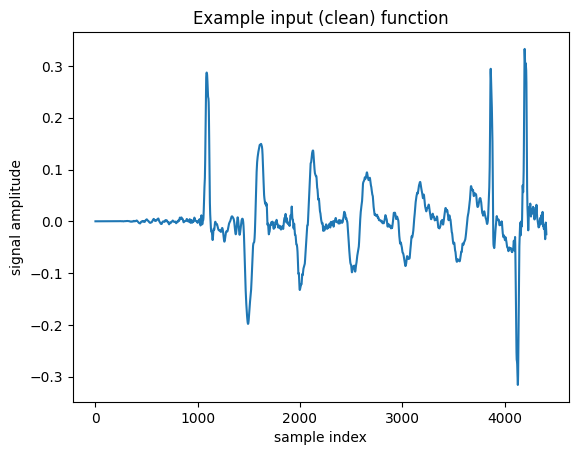

In [92]:
plt.plot(dataset[0])
plt.xlabel('sample index')
plt.ylabel('signal amplitude')
plt.title('Example input (clean) function')
plt.savefig('./audio_data_plots/clean_input_fn')

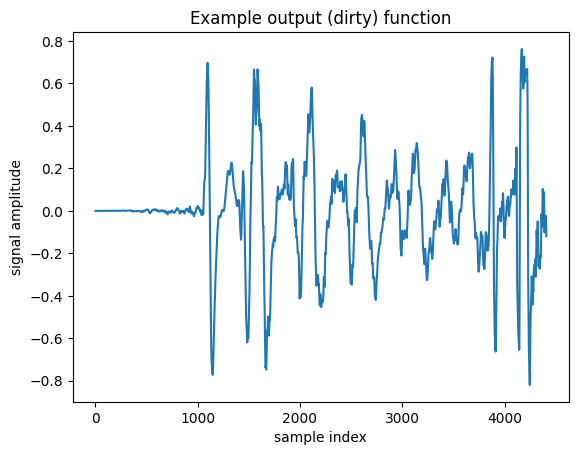

In [93]:
plt.plot(y_dataset[0])
plt.xlabel('sample index')
plt.ylabel('signal amplitude')
plt.title('Example output (dirty) function')
plt.savefig('./audio_data_plots/dirty_output_fn')

In [94]:
np.max(dataset), np.min(dataset)


(0.98353636, -0.7377748)

In [95]:

### output predictions from ML model are N functions  
def postprocess_audio(preds,
                      original_sps,
                      secs_per_fn=1,
                      shuffle=None, 
                      save=False, 
                      save_fp='output.mp3'):
    
    ## assume shuffle is w/o replacement 
    sampling_rate = preds.shape[1] / secs_per_fn #### each fn is 1 sec so the resolution is the sampl rate 
    if shuffle:
        deshuff = np.array([np.where(shuffle == i)[0] for i in range(len(shuffle))])
        preds = preds[deshuff]
    preds = preds.flatten()
    upsample = original_sps // sampling_rate
    upsampled_audio = signal.upfirdn([1],preds , up=upsample)
    print(upsampled_audio.shape)
    ## stack array now that it is in the right time order...
    if save:
        librosa.output.write_mp3(save_fp, upsampled_audio, original_sps)
    return upsampled_audio, original_sps


audio_array,sr = postprocess_audio(y_dataset,
                                   original_sps,
                                   secs_per_fn=0.1) ### sweeeett
    

(657090,)


In [96]:
from IPython.display import Audio
Audio(audio_array, rate=sr)


In [97]:
import soundfile as sf

save_fp = '/Users/mattlowery/Desktop/blues_driver_proj_results/blues_driver_label.mp3'
sf.write(save_fp, audio_array, sr)
